# Purpose: 
Generate a fire perimeter in GeoJSON based on the input pre and post flight images

In [1]:
import sys
from pathlib import Path

# Add the path to the utils folder to sys.path
utils_path = Path('../python').resolve()
sys.path.append(str(utils_path))

import numpy as np
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.plot import show
from sklearn.cluster import KMeans
from process_utils import (preprocess_data, 
                           superpixel_segmentation,
                           get_superpixel_model_labels,
                           convert_labels_to_gdf,
                           filter_by_area,
                           merge_geojson,
                           tv_denoise)
from nd_utils import (get_superpixel_means_as_features,
                      get_superpixel_stds_as_features,
                      get_array_from_features)
from rio_utils import (reproject_arr_to_match_profile)
from shapely.geometry import Polygon
from shapely.geometry import Point

In [2]:
def denoise(data, weight):
    mask = np.isnan(data)
    data[mask] = 9999
    data_tv = tv_denoise(data, weight)
    data_tv[mask] = np.nan

    return data_tv

---
## Load the images into arrays

**Parameter**:
- `tifs` (list): a list containing the paths to the preprocessed images
- `superpixel_labels_list` (list): a list containing the paths to the superpixel labels

In [3]:
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
        profile = ds.profile
        transform = ds.transform
    return band, profile, transform

In [6]:
# Path to the folder with the preprocessed images
data_dir = Path('/Volumes/BlueT7/test_bob')

tifs = sorted([tif for tif in (data_dir.glob('./*interpolated*.tif')) if "knear" in tif.name])

In [7]:
tifs

[PosixPath('/Volumes/BlueT7/test_bob/hv_0_25km_preprocessed_interpolated_knear_weight10.tif'),
 PosixPath('/Volumes/BlueT7/test_bob/hv_1_25km_preprocessed_interpolated_knear_weight10.tif')]

---
Open the preprocessed images and load the superpixel segmentation corresponded to the pre- and post- fire.

- Let `hv_0` correspond to the pre-fire image and `hv_1` correspond to the post-fire image. 
- Let `profile` and `transform` correspond to the pre-fire image.
- Let `superpixel_labels` be the output of the segmentation

In [8]:
# open the tifs
bands_tv, profiles, transforms = zip(*map(open_one, tifs))
hv_0 = bands_tv[0]
hv_1 = bands_tv[1]
profile = profiles[0]
transform = transforms[0]

In [9]:
hv_0 = denoise(hv_0,5)
hv_1 = denoise(hv_1,5)

---
This is the preprocessed raster image we will work with to extract the fire perimeter

In [10]:
# compute log ratio and filter out the vegetation gain by setting to no change.
log_ratio = np.log10(hv_0/hv_1)

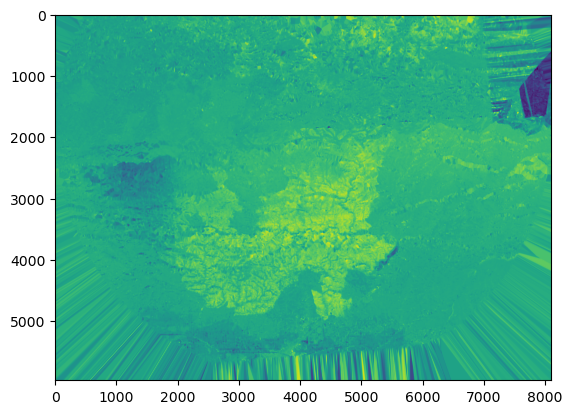

In [11]:
plt.imshow(log_ratio)

In [12]:
# Load if we have performed segmentation previously

superpixel_labels = np.load("/Volumes/BlueT7/test_bob/superpixel_labels_08525_08527_min1000_knear_weight10.npy")

In [41]:
# # Run this if we do not have the saved np array

# superpixel_labels = superpixel_segmentation(hv_0, hv_1, min_size=100)

# # save this np array to save run time for future runs
# superpixel_out_path = "latuna_bilinear_inc.npy"
# np.save(superpixel_out_path, superpixel_labels)

## Classification

In [13]:
np.seterr(divide='ignore', invalid='ignore')##
# Extracting features from the segmentation
mean_features = get_superpixel_means_as_features(superpixel_labels, log_ratio)
std_features = get_superpixel_stds_as_features(superpixel_labels, log_ratio)

In [14]:
# Selecting the K-Means model with n_clusters=2
model = KMeans(n_clusters=2, n_init=10,random_state=1)

---
Now we perform the classification and save the results to a GeoDataFrame

From the classification, 2 labels correponds to **{0: non-fire, 1:fire}**

In [15]:
labeled_data = get_superpixel_model_labels(np.hstack((mean_features, std_features)), model)
classes = get_array_from_features(superpixel_labels, labeled_data)
gdf = convert_labels_to_gdf(classes, profile)

## Post-Processing
Filtering out the false positive regions and select desired polygons for the perimeter

**Parameters**:
- `min_area_sq_km`(float): Filtering out the polygons with area less than this
- `top_k_index`(int): The top k largest post-filtered polygons will be returned for user selection

In [16]:
min_area_sq_km = 0.1
top_k_index = 20

In [17]:
gdf = filter_by_area(gdf, min_area_sq_km)
fire_gdf = gdf[gdf['class'] == 1] # by the ordering of the labels, '1' will be burned areas
fire_gdf = fire_gdf.sort_values(by='area_sq_km', ascending=False)
fire_gdf = fire_gdf.reset_index(drop=True)
fire_gdf = fire_gdf[0:top_k_index]

---
Here's a peek of the GeoDataFrame containing the top 10 largest fire perimeters

In [18]:
fire_gdf

,geometry,class,area_sq_km
0,"POLYGON ((-117.76917 34.34689, -117.76917 34.3...",1.0,493.998766
1,"POLYGON ((-117.89068 34.439, -117.89068 34.436...",1.0,24.342348
2,"POLYGON ((-117.82184 34.439, -117.82184 34.438...",1.0,22.089448
3,"POLYGON ((-117.94807 34.439, -117.94807 34.437...",1.0,15.163994
4,"POLYGON ((-117.70544 34.42695, -117.70544 34.4...",1.0,6.320015
5,"POLYGON ((-117.72817 34.2341, -117.72817 34.23...",1.0,5.620284
6,"POLYGON ((-117.94257 34.13543, -117.94257 34.1...",1.0,3.805975
7,"POLYGON ((-118.08975 34.17471, -118.08975 34.1...",1.0,3.408345
8,"POLYGON ((-117.84057 34.41711, -117.84057 34.4...",1.0,3.217193
9,"POLYGON ((-117.70544 34.40806, -117.70544 34.4...",1.0,3.130472


## Polygon Selection:

Select polygons to keep as part of the output fire perimeter based on the plot below

**Parameters**:
- `longitude`(float): longitude of the rough area of fire
- `latitude`(float): latitude of the rough area of fire

In [19]:
def make_center_point(longitude, latitude):
    buffer_point = Point(longitude, latitude)
    buffer_gdf = gpd.GeoDataFrame(geometry=[buffer_point])

    return buffer_gdf


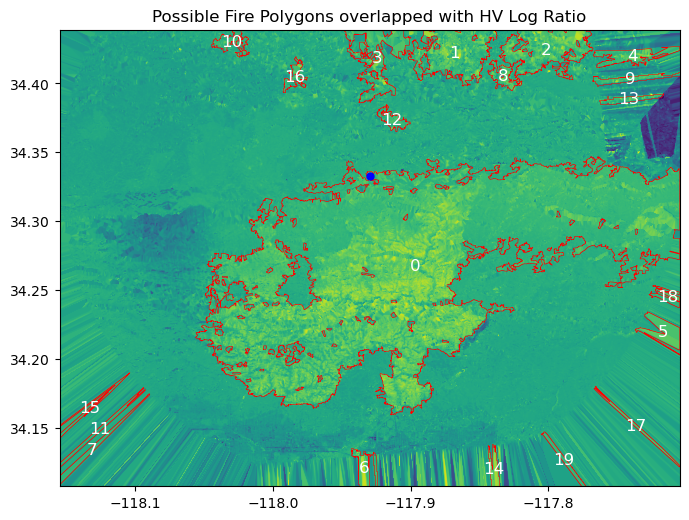

In [20]:
# Plot the GeoDataFrame on top of the log_ratio image
fig, ax = plt.subplots(figsize=(8, 8))
show(log_ratio, ax=ax, transform=transform, cmap='viridis', interpolation='none')
fire_gdf.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=0.4)
for idx, polygon in fire_gdf.iterrows():
    x, y = polygon.geometry.centroid.x, polygon.geometry.centroid.y
    ax.text(x, y, str(idx), fontsize=12, color='white', ha='center', va='center')
    
make_center_point(-117.9297578, 34.332527).plot(ax=ax, color='blue', markersize=25)  # Plot the buffer point in blue

plt.title('Possible Fire Polygons overlapped with HV Log Ratio')
plt.show()


**Parameter**:
- `index_to_keep`: set this to [-1] if you would like to keep all the polygons. Else, select the index on top of the polygons to keep.

In [51]:
index_to_keep = [0]

In [52]:
if index_to_keep == [-1]:
    target_gdf = fire_gdf
else:
    target_gdf = fire_gdf.loc[index_to_keep]

In [53]:
# Combine the selected polygons into a single multi-polygon shape
merged_geom = target_gdf.unary_union
reg_gdf = gpd.GeoDataFrame(geometry=[merged_geom])
reg_gdf.crs = gdf.crs
reg_gdf = reg_gdf.to_crs('epsg:3857')
reg_gdf['area_sq_km'] = reg_gdf.geometry.area / 1000000
reg_gdf = reg_gdf.to_crs('epsg:4326')

/var/folders/jd/qlykp1md3g19mkq0180ghcs40000gn/T/ipykernel_22974/125331532.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  merged_geom = target_gdf.unary_union


<Axes: >

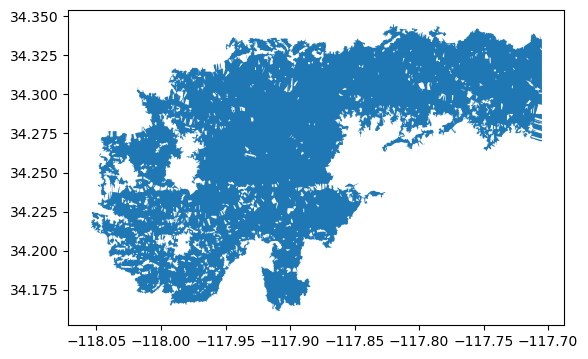

In [54]:
# This is what the regular perimeter will look like
reg_gdf.plot()

In [55]:
# from stackoverflow
# https://stackoverflow.com/questions/61427797/filling-a-hole-in-a-multipolygon-with-shapely-netherlands-2-digit-postal-codes
no_holes = gpd.GeoSeries([Polygon(p.exterior) for p in target_gdf["geometry"]])

filled_gdf = gpd.GeoDataFrame({'geometry': no_holes})
filled_gdf.crs = gdf.crs
filled_gdf = filled_gdf.to_crs('epsg:3857')
filled_gdf['area_sq_km'] = filled_gdf.geometry.area / 1000000
filled_gdf = filled_gdf.to_crs('epsg:4326')

<Axes: >

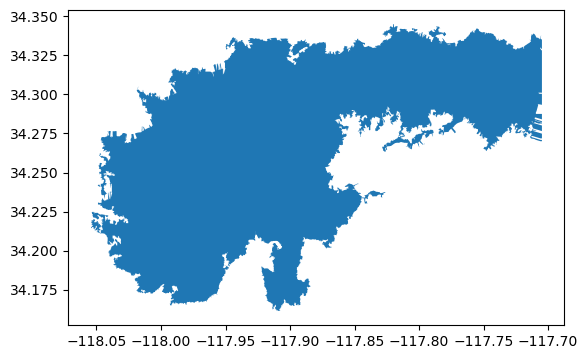

In [56]:
# Perimeter after filling in the holes
filled_gdf.plot()

<Axes: >

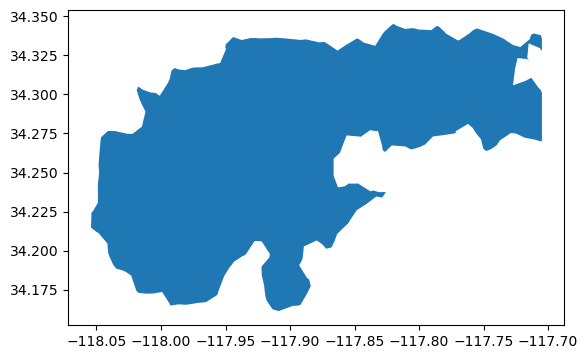

In [57]:
# Perimeter after applying concave hull

concave_gdf = reg_gdf.concave_hull(0.05)
concave_gdf.plot()

<Axes: >

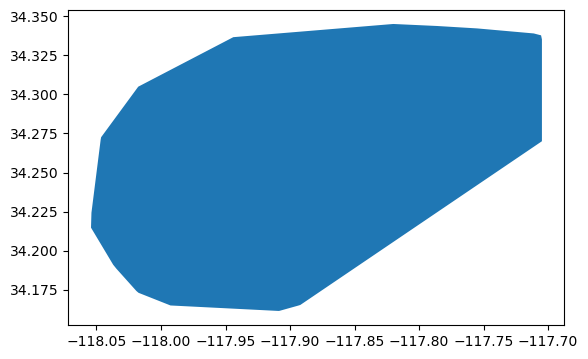

In [58]:
# Perimeter after applying convex hull

convex_gdf = reg_gdf.convex_hull
convex_gdf.plot()

**Parameter**:
- `output_name`: name of the output geojson file. [**.geojson**]

In [31]:
# choose one of the gdfs to output: reg_gdf, filled_gdf, concave_gdf, convex_gdf
output_name = 'fishla_weight_inc.geojson'
filled_gdf.to_file(output_name, driver='GeoJSON')

## Merge GeoJSON if multiple flight lines
Function to merge the output GeoJSON files into a single one if the interested fire involved multiple UAVSAR flight lines. ex: Bobcat, Station fires

**Parameters**:
- `geojson_paths`(list): A list storing the paths to the generated GeoJSONs
- `out_geojson_name`(str): Name for the merged GeoJSON file. [**.geojson**]

In [ ]:
geojson_paths = ['bobcat_perimeter_bilinear_inc_south.geojson', 'bobcat_perimeter_bilinear_inc_north.geojson']
out_geojson_name = 'bobcat_perimeter_inc_uavsar.geojson'

In [ ]:
# Merge and output
output_gdf = merge_geojson(geojson_paths)
output_gdf.to_file(out_geojson_name, driver='GeoJSON')